In [10]:
import os

if os.path.exists("/home/alphat"):
    os.chdir("/home/alphat/neuvisys-analysis/src")
    home = "/home/alphat/"
else:
    os.chdir("/home/thomas/neuvisys-analysis/src")
    home = "/home/thomas/"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pdf2image import convert_from_path

from src.spiking_network.network.neuvisys import SpikingNetwork, clean_network
from src.events.tools.read_write.aedat_tools import (
    load_aedat4,
)
from src.events.tools.read_write.events_tools import (
    write_npz,
    npaedat_to_np,
    ros_to_npy,
)
from src.events.tools.modification.event_modification import (
    show_event_images,
    rectify_events,
    remove_events,
)
from src.frames.frame_analysis import (
    load_frames,
    rectify_frames,
    write_frames,
    stereo_matching,
)
from src.spiking_network.analysis.network_display import (
    display_network,
    load_array_param,
    complex_cells_directions,
)
from src.spiking_network.analysis.network_statistics import (
    compute_disparity_0,
    rf_matching,
    direction_norm_length,
    orientation_norm_length,
    direction_selectivity,
    orientation_selectivity,
    update_dataframe,
)
from src.spiking_network.planning.network_planner import (
    create_networks,
    random_params,
    launch_neuvisys_multi_pass,
    toggle_learning,
    divide_visual_field,
)
from src.spiking_network.gabor.gabbor_fitting import (
    create_gabor_basis,
    hists_preferred_orientations,
    plot_preferred_orientations,
)
from src.spiking_network.analysis.parameter_analysis import (
    correlation_matrix,
    scatter_mat,
)

network_path = home + "neuvisys-dv/configuration/network/"

## Load Network

In [4]:
spinet = SpikingNetwork(network_path)

## Display Weights

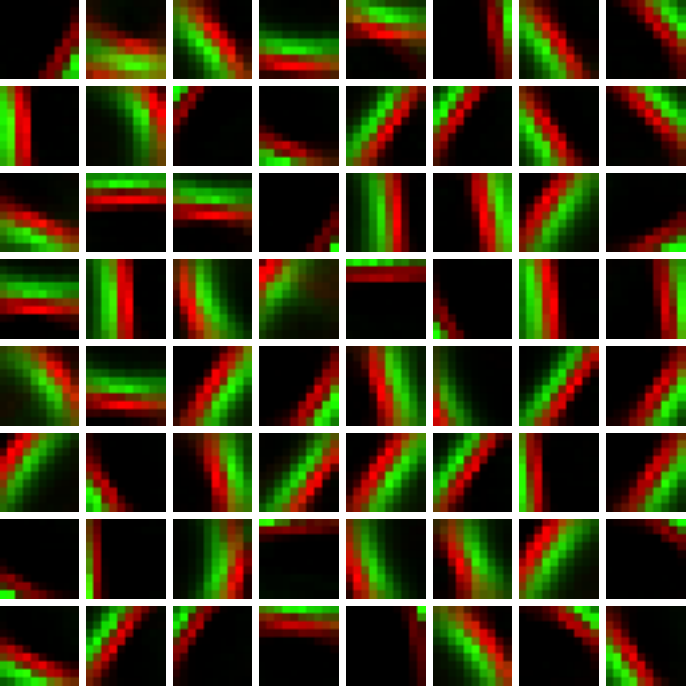

In [16]:
display_network([spinet])
convert_from_path(network_path + "figures/0/weight_sharing_0.pdf")[0].show()

## !!!Delete Weights!!!

In [3]:
clean_network(network_path, [0, 1, 2, 3])

FileNotFoundError: [Errno 2] No such file or directory: '/home/thomas/neuvisys-dv/configuration/network/weights/2/'

## Create networks

In [ ]:
# params = {"simple_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}, "complex_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}}
# create_networks(home + "neuvisys-dv/cmake-build-release", home + "Bureau", 2, {})
random_params("/home/thomas/neuvisys-dv/cmake-build-release", "/home/thomas/Desktop/Networks2", 40)

## Load events

In [ ]:
events = load_aedat4(home + "Desktop/shapes.aedat4")

## Load rosbag and convert it to npdat

In [ ]:
left_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/left/events")
right_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/right/events")

## Save aedat file as numpy npz file

In [ ]:
write_npz(home + "Desktop/shape_hovering_fast", events)  # mono
# write_npz(home + "Desktop/shapes", (left_events, right_events)) # stereo

## Load frames

In [ ]:
frames = load_frames("/media/alphat/DisqueDur/0_Thesis/pavin.aedat4")

## Create Matlab weight.mat

In [ ]:
basis = spinet.generate_weight_mat()

## Load various neuron informations

In [ ]:
simpa_decay, compa_decay = load_array_param(spinet, "learning_decay")
simpa_spike, compa_spike = load_array_param(spinet, "count_spike")

## Load and create gabor basis

In [ ]:
spinet.generate_weight_images()
gabor_params_l = create_gabor_basis(spinet, "None", nb_ticks=8)
# gabor_params_l = create_gabor_basis(spinet, "left/", nb_ticks=8)
# gabor_params_r = create_gabor_basis(spinet, "right/", nb_ticks=8)

## Create plots for preferred orientations and directions

In [ ]:
oris, oris_r = hists_preferred_orientations(spinet)
plot_preferred_orientations(spinet, oris, oris_r)

## Direction and orientation selectivity

In [ ]:
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
dir_vec, ori_vec = complex_cells_directions(spinet, rotations)

angles = np.pi * rotations / 180

dirs = []
dis = []
for i in range(144):
    dirs.append(direction_norm_length(spinet.directions[:, i], angles))
    dis.append(direction_selectivity(spinet.directions[:, i]))
oris = []
ois = []
for i in range(144):
    oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
    ois.append(orientation_selectivity(spinet.orientations[:, i]))